# 6 Clustering: method k-Means (Control+Infected)
#### Dataset1+Dataset2 (Arabidopsis Col-0 + Arabidopsis infected)

Cynthia Soto <br>
Fecha: 6 de Octubre 2020 <br>
Datatype representation: normalized values in log2 scale (genome name reference) <br>
Data quantify with HTSeq (alignments done with STAR SA)  <br>

**Details of the algorithm is a fundamental step in the process of writing your k-means clustering pipeline in Python. What I show here will help you decide if k-means is the right choice to solve your clustering problem.**

**Data Assumptions:** <br>
Datasets are transformed to log2 scale. <br>
Damage samples are removed from the matrix <br>
Gene IDs in ceros across samples are removed from the matrix <br>
Distributions are known. <br>

<br>
**Composition of the matrix:** <br>
18 RNASeq samples (8 control + 10 infected)<br>
Matrix size to perform this clustering is 88% (features:genes) respecting the original one (due ceros removed).<br>  
Original matriz shape (27654 x 18). After features with ceros removed (24325 x 18) <br>

**Workflow:** <br>
1) xxs) <br>
2) xx  <br> 
3) xx  <br>
4) xx.  <br>

In [106]:
# Libraries required
import os 
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

In [107]:
try:
    # Change the current working Directory    
    os.chdir("/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/")
    print("Directory changed:", os.getcwd() )
except OSError:
    print("Can't change the Current Working Directory")    

Directory changed: /home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis


### The first step is to randomly select k centroids, where k is equal to the number of clusters you choose. 
Centroids are data points representing the center of a cluster. <br>
The main element of the algorithm works by a two-step process called **expectation-maximization**. The expectation step assigns each data point to its nearest centroid. Then, the maximization step computes the mean of all the points for each cluster and sets the new centroid. <br><br>
The quality of the cluster assignments is determined by computing the sum of the **squared error (SSE)** after the centroids converge, or match the previous iteration’s assignment. The **SSE is defined as the sum of the squared Euclidean distances of each point to its closest centroid**. Since this is a measure of error, the objective of k-means is to try to minimize this value. <br><br>
The initialization of the centroids is an important step. It also highlights the use of SSE as a measure of clustering performance. After choosing a number of clusters and the initial centroids, the expectation-maximization step is repeated until the centroid positions reach convergence and are unchanged.

The **random initialization** step causes the k-means algorithm to be **nondeterministic**, meaning that cluster assignments will vary if you run the same algorithm twice on the same dataset. Researchers commonly run several initializations of the entire k-means algorithm and choose the cluster assignments from the initialization with the lowest SSE

In [109]:
# I recommend install with pip
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# more details about this run: https://realpython.com/k-means-clustering-python/

In [118]:
# Load array (18 samples)
df1=pd.read_csv("all_log2_dropped20ceros_SRR.csv", sep='\t', nrows=2000)
## remove unnamed cols
df1.drop(df1.columns[df1.columns.str.contains('Unnamed',case=False)],axis=1,inplace=True)

# Remove samples of the original matrix
df1.drop(['zero-counter'], axis = 1, inplace = True) 
print(df1.shape)
df1.head()

(2000, 21)


,Genes,SRR3383640,SRR3383821,SRR3383782,SRR6283145,SRR3383641,SRR3383783,SRR3383822,SRR6283144,SRR364399,...,SRR6283147,SRR3383696,SRR3383780,SRR10586397pe,SRR10586399pe,SRR3383779,SRR3383697,SRR364390,SRR364389,SRR364398
0,AT1G01010,6.523562,7.055282,6.845490,6.266787,7.592457,5.857981,6.066089,7.507795,6.930737,...,5.614710,6.539159,7.044394,8.577429,8.607330,6.044394,6.988685,6.965784,6.977280,6.942515
1,AT1G01020,6.768184,7.189825,7.813781,7.459432,8.066089,6.882643,6.539159,7.357552,6.727920,...,5.357552,7.149747,7.400879,7.228819,7.139551,6.918863,7.375039,7.467606,7.330917,6.954196
2,AT1G01030,3.807355,3.321928,5.169925,4.392317,4.523562,3.807355,4.087463,4.700440,3.584963,...,5.087463,2.807355,4.523562,5.727920,5.906891,4.321928,4.392317,3.169925,3.169925,3.459432
3,AT1G01040,10.005625,9.992938,11.214926,11.311748,11.165535,10.371777,9.319672,11.283667,9.262095,...,5.857981,10.047124,10.251482,10.167418,10.200899,9.812177,10.382624,9.743151,9.842350,9.303781
4,AT1G01050,9.733015,9.419960,11.379920,10.581201,10.854868,10.250298,8.668885,10.817783,7.954196,...,4.247928,10.284246,9.768184,9.967226,9.744834,9.481799,10.651949,8.689998,8.774787,8.016808


In [119]:
## Descriptive Statistics of Samples
df1.describe()

,SRR3383640,SRR3383821,SRR3383782,SRR6283145,SRR3383641,SRR3383783,SRR3383822,SRR6283144,SRR364399,SRR6283148,SRR6283147,SRR3383696,SRR3383780,SRR10586397pe,SRR10586399pe,SRR3383779,SRR3383697,SRR364390,SRR364389,SRR364398
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,5.765404,6.003823,6.691325,6.336292,6.581819,5.808282,5.467601,6.299461,5.624442,3.648981,3.712695,5.843158,5.896893,6.921603,6.850224,5.554672,6.056066,5.850153,5.871207,5.618887
std,3.444019,3.586396,3.787210,3.833694,3.782046,3.549331,3.433839,3.902559,3.387180,3.330548,3.372859,3.539734,3.593258,3.396248,3.411464,3.437500,3.616650,3.471207,3.475969,3.385853
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.169925,3.906891,3.000000,3.584963,3.000000,2.584963,2.951839,2.807355,0.000000,0.000000,2.807355,3.000000,4.857981,4.686294,2.584963,3.000000,3.169925,3.169925,2.807355
50%,6.523562,6.807355,7.603622,7.361937,7.599913,6.599913,6.238373,7.189825,6.247928,3.169925,3.321928,6.741467,6.781360,7.588710,7.491853,6.339850,7.022368,6.727920,6.714246,6.228819
75%,8.397673,8.777249,9.529431,9.315150,9.486332,8.546894,8.092757,9.334272,8.161130,6.189825,6.266787,8.516684,8.697836,9.478264,9.451719,8.213090,8.764860,8.574593,8.569856,8.176172
max,14.440480,16.269839,16.632044,16.902222,15.207548,15.486207,15.401346,18.067209,16.025053,16.665294,16.796078,14.546834,15.551888,16.978733,16.908815,14.332386,14.962218,17.189023,17.207901,16.023841


### Note: array has samples as columns and genes as rows 

In [120]:
df1.T
df1.set_index('Genes',inplace=True)

In [121]:
df1

,SRR3383640,SRR3383821,SRR3383782,SRR6283145,SRR3383641,SRR3383783,SRR3383822,SRR6283144,SRR364399,SRR6283148,SRR6283147,SRR3383696,SRR3383780,SRR10586397pe,SRR10586399pe,SRR3383779,SRR3383697,SRR364390,SRR364389,SRR364398
Genes,,,,,,,,,,,,,,,,,,,,
AT1G01010,6.523562,7.055282,6.845490,6.266787,7.592457,5.857981,6.066089,7.507795,6.930737,3.000000,5.614710,6.539159,7.044394,8.577429,8.607330,6.044394,6.988685,6.965784,6.977280,6.942515
AT1G01020,6.768184,7.189825,7.813781,7.459432,8.066089,6.882643,6.539159,7.357552,6.727920,5.129283,5.357552,7.149747,7.400879,7.228819,7.139551,6.918863,7.375039,7.467606,7.330917,6.954196
AT1G01030,3.807355,3.321928,5.169925,4.392317,4.523562,3.807355,4.087463,4.700440,3.584963,4.459432,5.087463,2.807355,4.523562,5.727920,5.906891,4.321928,4.392317,3.169925,3.169925,3.459432
AT1G01040,10.005625,9.992938,11.214926,11.311748,11.165535,10.371777,9.319672,11.283667,9.262095,6.228819,5.857981,10.047124,10.251482,10.167418,10.200899,9.812177,10.382624,9.743151,9.842350,9.303781
AT1G01050,9.733015,9.419960,11.379920,10.581201,10.854868,10.250298,8.668885,10.817783,7.954196,4.700440,4.247928,10.284246,9.768184,9.967226,9.744834,9.481799,10.651949,8.689998,8.774787,8.016808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AT1G20880,7.022368,7.554589,7.894818,9.226412,8.499846,7.434628,6.954196,9.224002,6.599913,5.554589,5.584963,7.554589,7.686501,8.566054,8.611025,6.845490,7.832890,7.219169,7.523562,6.794416
AT1G20890,6.523562,6.807355,7.467606,8.422065,7.686501,6.965784,5.977280,8.471675,5.781360,1.000000,2.321928,6.781360,7.087463,7.276124,7.169925,6.339850,7.199672,7.011227,7.108524,6.321928
AT1G20900,0.000000,1.000000,1.000000,4.754888,0.000000,0.000000,0.000000,3.584963,1.000000,1.000000,2.584963,0.000000,0.000000,4.643856,3.459432,0.000000,0.000000,0.000000,1.584963,0.000000


### standardize the data to normal distribution

In [122]:
#standardize the data to normal distribution
from sklearn import preprocessing
dataset1_standardized = preprocessing.scale(df1)
dataset1_standardized = pd.DataFrame(dataset1_standardized)

In [123]:
dataset1_standardized

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.220193,0.293253,0.040717,-0.018135,0.267287,0.014006,0.174335,0.309703,0.385755,-0.194906,0.564059,0.196674,0.319428,0.487667,0.515188,0.142500,0.257933,0.321476,0.318285,0.391027
1,0.291238,0.330777,0.296455,0.293039,0.392550,0.302769,0.312136,0.271195,0.325862,0.444573,0.487796,0.369213,0.418663,0.090480,0.084831,0.396955,0.364786,0.466079,0.420048,0.394478
2,-0.568678,-0.747984,-0.401821,-0.507203,-0.544354,-0.563889,-0.402023,-0.409839,-0.602268,0.243399,0.407699,-0.857850,-0.382292,-0.351559,-0.276588,-0.358706,-0.460140,-0.772324,-0.777325,-0.637947
3,1.231492,1.112569,1.194740,1.298148,1.212271,1.286055,1.122078,1.277483,1.074216,0.774792,0.636203,1.187947,1.212181,0.955945,0.982426,1.238857,1.196588,1.121792,1.142742,1.088593
4,1.152317,0.952765,1.238317,1.107540,1.130108,1.251821,0.932509,1.158074,0.687987,0.315780,0.158728,1.254952,1.077646,0.896985,0.848707,1.142723,1.271075,0.818319,0.835539,0.708395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.365061,0.432511,0.317858,0.754062,0.507267,0.458326,0.433034,0.749578,0.288061,0.572304,0.555237,0.483612,0.498171,0.484317,0.516271,0.375605,0.491413,0.394490,0.475484,0.347275
1996,0.220193,0.224106,0.205025,0.544199,0.292159,0.326200,0.148466,0.556752,0.046338,-0.795558,-0.412444,0.265115,0.331417,0.104412,0.093737,0.228473,0.316285,0.334571,0.356052,0.207693
1997,-1.674453,-1.395572,-1.503151,-0.412605,-1.740715,-1.636853,-1.592669,-0.695743,-1.365620,-0.795558,-0.334439,-1.651146,-1.641509,-0.670833,-0.994189,-1.616309,-1.674915,-1.685758,-1.233416,-1.659934
1998,0.196778,0.131616,0.402242,0.580773,0.361416,0.460670,0.098968,0.639472,0.046338,0.015454,-0.160963,0.323700,0.348755,0.300675,0.215427,0.382843,0.334847,0.202988,0.273078,0.040177


### Find the appropriate cluster number with "The Elbow Method"

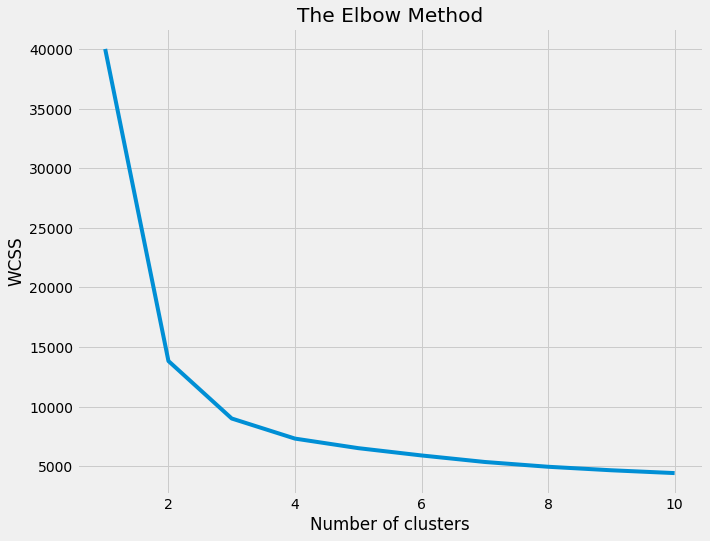

In [124]:
# find the appropriate cluster number with standarized data function applied to the array
plt.figure(figsize=(10, 8))
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(dataset1_standardized)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### K-Means Clustering

In [125]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(dataset1_standardized)#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans
y_kmeans1=y_kmeans+1# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)# Adding cluster to the Dataset1
df1['cluster'] = cluster#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(df1.groupby('cluster').mean(),1))
kmeans_mean_cluster

,SRR3383640,SRR3383821,SRR3383782,SRR6283145,SRR3383641,SRR3383783,SRR3383822,SRR6283144,SRR364399,SRR6283148,SRR6283147,SRR3383696,SRR3383780,SRR10586397pe,SRR10586399pe,SRR3383779,SRR3383697,SRR364390,SRR364389,SRR364398
cluster,,,,,,,,,,,,,,,,,,,,
